<a href="https://colab.research.google.com/github/yuvipaloozie/educational-notebooks/blob/main/MNISTwithML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import hog

# Configuration for clearer plots
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")
print("Libraries imported.")

Libraries imported.


X_train shape: (60000, 784)
y_train shape: (10000, 784)

Plotting 3 random samples for each digit:


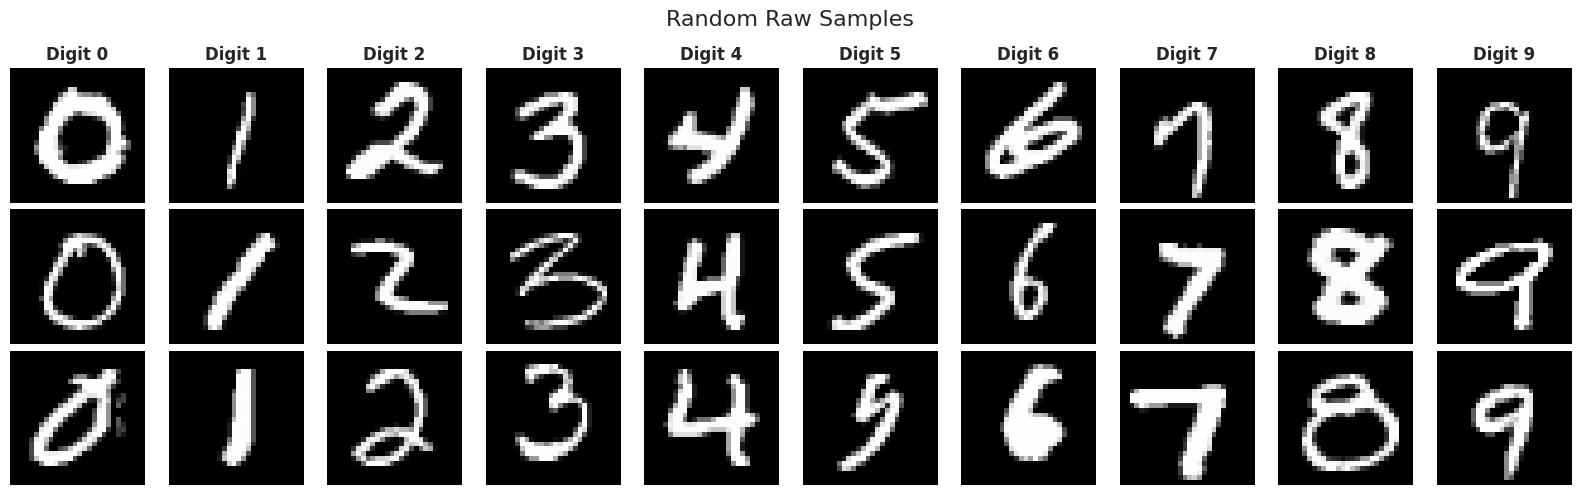

Computing mean digits for visualization:


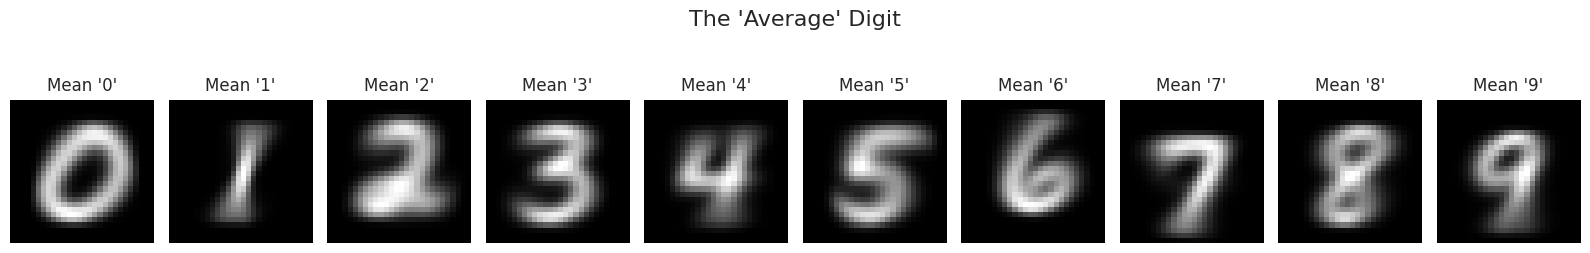

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
#Load and reshape for ML model
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig)= mnist.load_data()
X_train = X_train_orig.reshape(X_train_orig.shape[0], 784).astype(np.uint8)
X_test = X_test_orig.reshape(X_test_orig.shape[0], 784).astype(np.uint8)

y_train = y_train_orig.astype(np.uint8)
y_test = y_test_orig.astype(np.uint8)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {X_test.shape}")
print("\nPlotting 3 random samples for each digit:")

fig, axes = plt.subplots(3, 10, figsize=(16, 5))
for digit in range(10):
  indices = np.where(y_train == digit)[0]
  random_indices = np.random.choice(indices, 3, replace=False)

  for row in range(3):
        ax = axes[row, digit]
        img = X_train[random_indices[row]].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        if row == 0:
            ax.set_title(f"Digit {digit}", fontsize=12, fontweight='bold')
        ax.axis('off')

plt.suptitle("Random Raw Samples", fontsize=16)
plt.tight_layout()
plt.show()

print("Computing mean digits for visualization:")
mean_images=[]

for digit in range(10):
    digit_imgs = X_train[y_train == digit].reshape(-1, 28, 28)
    mean_img = np.mean(digit_imgs, axis=0)
    mean_images.append(mean_img)

fig, axes = plt.subplots(1, 10, figsize=(16, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(mean_images[i], cmap='gray')
    ax.set_title(f"Mean '{i}'")
    ax.axis('off')

plt.suptitle("The 'Average' Digit", fontsize=16)
plt.tight_layout()
plt.show()

1. Training Baseline Model (KNN) on Raw Pixels
Baseline Accuracy (Raw Pixels): 92.35%
Time taken: 1.88s

2. Visualizing Nearest Neighbors:


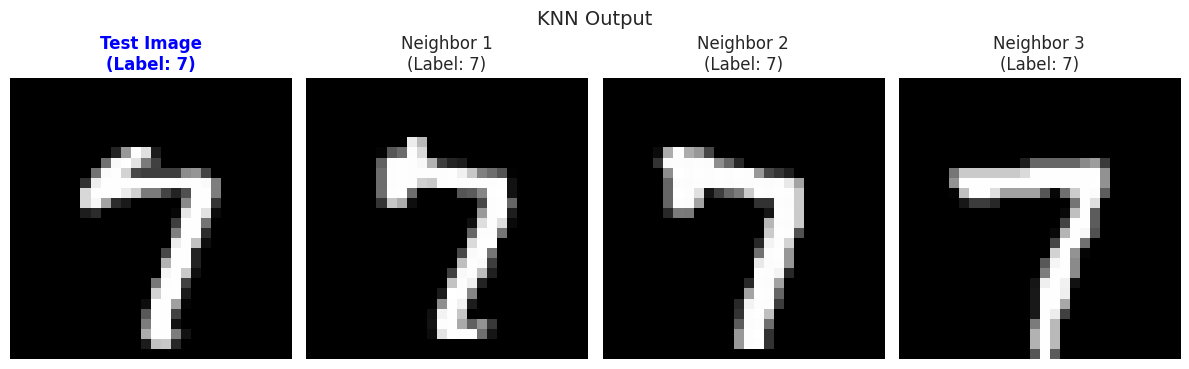


3. Visualizing Data Sparsity:


Text(0, 0.5, 'Frequency (Log)')

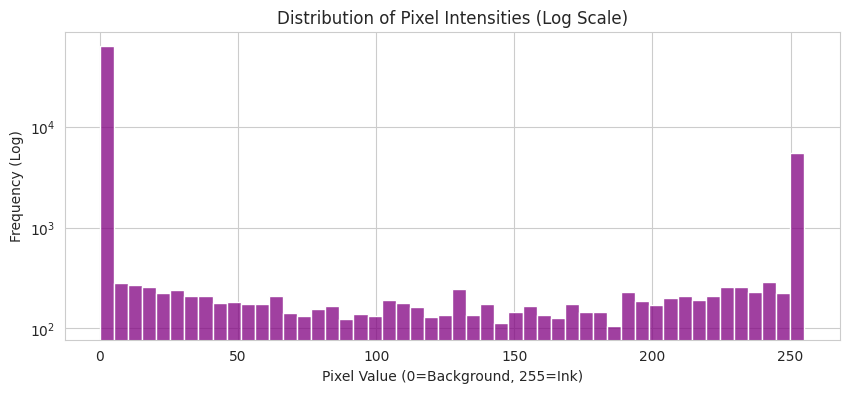

In [23]:

from sklearn.neighbors import KNeighborsClassifier
import time

print("1. Training Baseline Model (KNN) on Raw Pixels")
start_time = time.time()
knn_baseline = KNeighborsClassifier(n_neighbors=3)
knn_baseline.fit(X_train[:10000], y_train[:10000])

baseline_acc = knn_baseline.score(X_test[:2000], y_test[:2000])
print(f"Baseline Accuracy (Raw Pixels): {baseline_acc*100:.2f}%")
print(f"Time taken: {time.time() - start_time:.2f}s")


print("\n2. Visualizing Nearest Neighbors:")

test_idx = np.random.randint(0, 1000)
test_image = X_test[test_idx]
true_label = y_test[test_idx]

distances, indices = knn_baseline.kneighbors([test_image])

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(test_image.reshape(28, 28), cmap='gray')
axes[0].set_title(f"Test Image\n(Label: {true_label})", fontweight='bold', color='blue')
axes[0].axis('off')

for i in range(3):
    neighbor_idx = indices[0][i]
    neighbor_img = X_train[neighbor_idx].reshape(28, 28)
    neighbor_label = y_train[neighbor_idx]

    ax = axes[i+1]
    ax.imshow(neighbor_img, cmap='gray')
    ax.set_title(f"Neighbor {i+1}\n(Label: {neighbor_label})")
    ax.axis('off')

plt.suptitle(f"KNN Output", fontsize=14)
plt.tight_layout()
plt.show()

print("\n3. Visualizing Data Sparsity:")
plt.figure(figsize=(10, 4))

pixel_values = X_train[:100].flatten()
sns.histplot(pixel_values, bins=50, color='purple', kde=False)
plt.yscale('log')
plt.title("Distribution of Pixel Intensities (Log Scale)")
plt.xlabel("Pixel Value (0=Background, 255=Ink)")
plt.ylabel("Frequency (Log)")


Applying Deskewing to entire dataset
Deskewing Complete.

Visualizing the effect on specific slanted digits


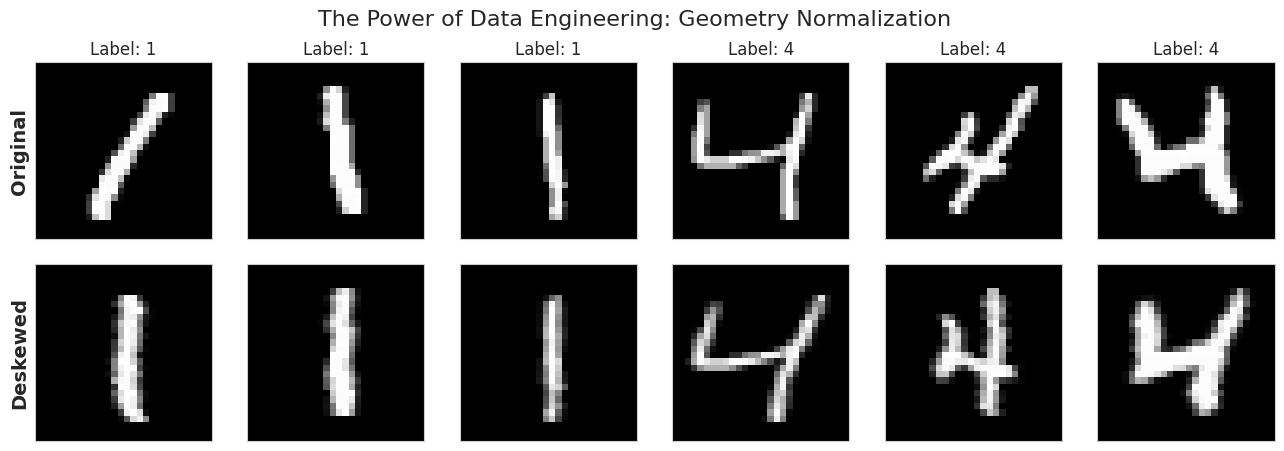

In [18]:
def deskew(img):
    """
    Takes a 2D image (28x28), calculates its "moments" (center of mass),
    and applies an affine transformation to straighten it.
    """
    m = cv2.moments(img)

    if abs(m['mu02']) < 1e-2:
        return img.copy()

    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * 28 * skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

print("Applying Deskewing to entire dataset")

X_train_deskewed_img = np.array([deskew(img.reshape(28, 28)) for img in X_train])
X_test_deskewed_img = np.array([deskew(img.reshape(28, 28)) for img in X_test])

X_train_deskewed = X_train_deskewed_img.reshape(X_train.shape[0], -1)
X_test_deskewed = X_test_deskewed_img.reshape(X_test.shape[0], -1)

print("Deskewing Complete.")

print("\nVisualizing the effect on specific slanted digits")

target_digits = [1, 7]
example_indices = []
for d in target_digits:
    # Get first 3 instances of this digit
    indices = np.where(y_train == d)[0][:3]
    example_indices.extend(indices)

fig, axes = plt.subplots(2, 6, figsize=(16, 5))
plt.subplots_adjust(hspace=0.1)

for i, idx in enumerate(example_indices):
    # Original (Top Row)
    axes[0, i].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    if i == 0: axes[0, i].set_ylabel("Original", fontsize=14, fontweight='bold')
    axes[0, i].set_title(f"Label: {y_train[idx]}")
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    # Deskewed (Bottom Row)
    axes[1, i].imshow(X_train_deskewed_img[idx], cmap='gray')
    if i == 0: axes[1, i].set_ylabel("Deskewed", fontsize=14, fontweight='bold')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])

plt.suptitle("The Power of Data Engineering: Geometry Normalization", fontsize=16)
plt.show()

Computing PCA for 3D visualization:
Plotting 3D Manifolds:


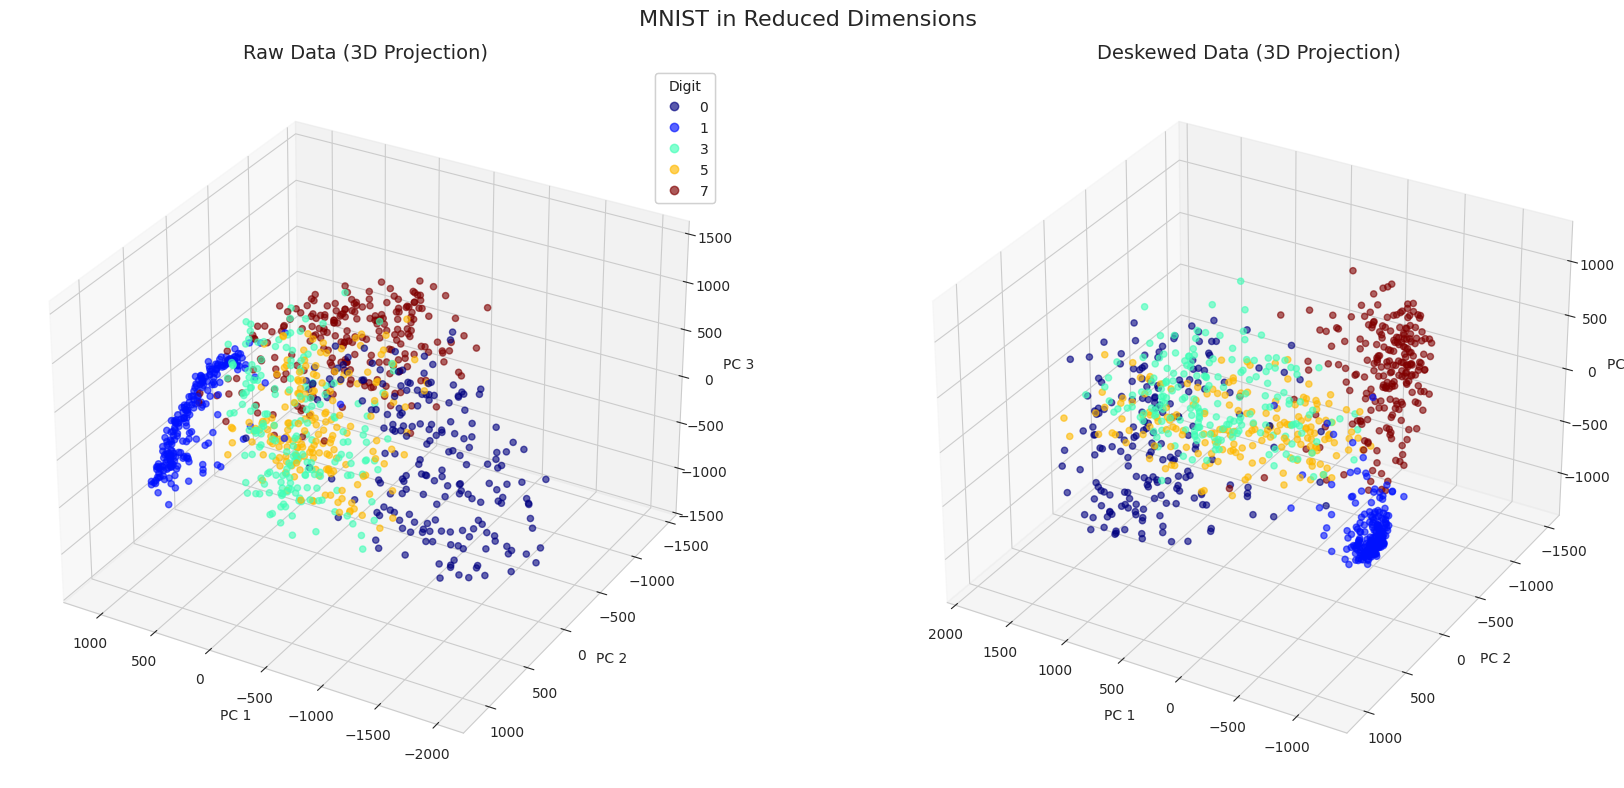

In [22]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

print("Computing PCA for 3D visualization:")

target_digits = [0, 1, 3, 7, 5]
subset_mask = np.isin(y_train[:2000], target_digits)
y_subset = y_train[:2000][subset_mask]

pca = PCA(n_components=3)
X_raw_3d = pca.fit_transform(X_train[:2000][subset_mask])


X_deskew_3d = pca.fit_transform(X_train_deskewed[:2000][subset_mask])

print("Plotting 3D Manifolds:")

# Setup the plot
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(121, projection='3d')
# Scatter plot
scatter1 = ax1.scatter(
    X_raw_3d[:, 0], X_raw_3d[:, 1], X_raw_3d[:, 2],
    c=y_subset, cmap='jet', alpha=0.6, s=20
)
ax1.set_title("Raw Data (3D Projection)", fontsize=14)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.set_zlabel("PC 3")
ax1.view_init(elev=30, azim=120) # Adjust angle for best view

ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    X_deskew_3d[:, 0], X_deskew_3d[:, 1], X_deskew_3d[:, 2],
    c=y_subset, cmap='jet', alpha=0.6, s=20
)
ax2.set_title("Deskewed Data (3D Projection)", fontsize=14)
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.set_zlabel("PC 3")
ax2.view_init(elev=30, azim=120)

# Add a color bar
legend1 = ax1.legend(*scatter1.legend_elements(), title="Digit")
ax1.add_artist(legend1)

plt.suptitle("MNIST in Reduced Dimensions", fontsize=16)
plt.tight_layout()
plt.show()

Visualizing HOG Features:


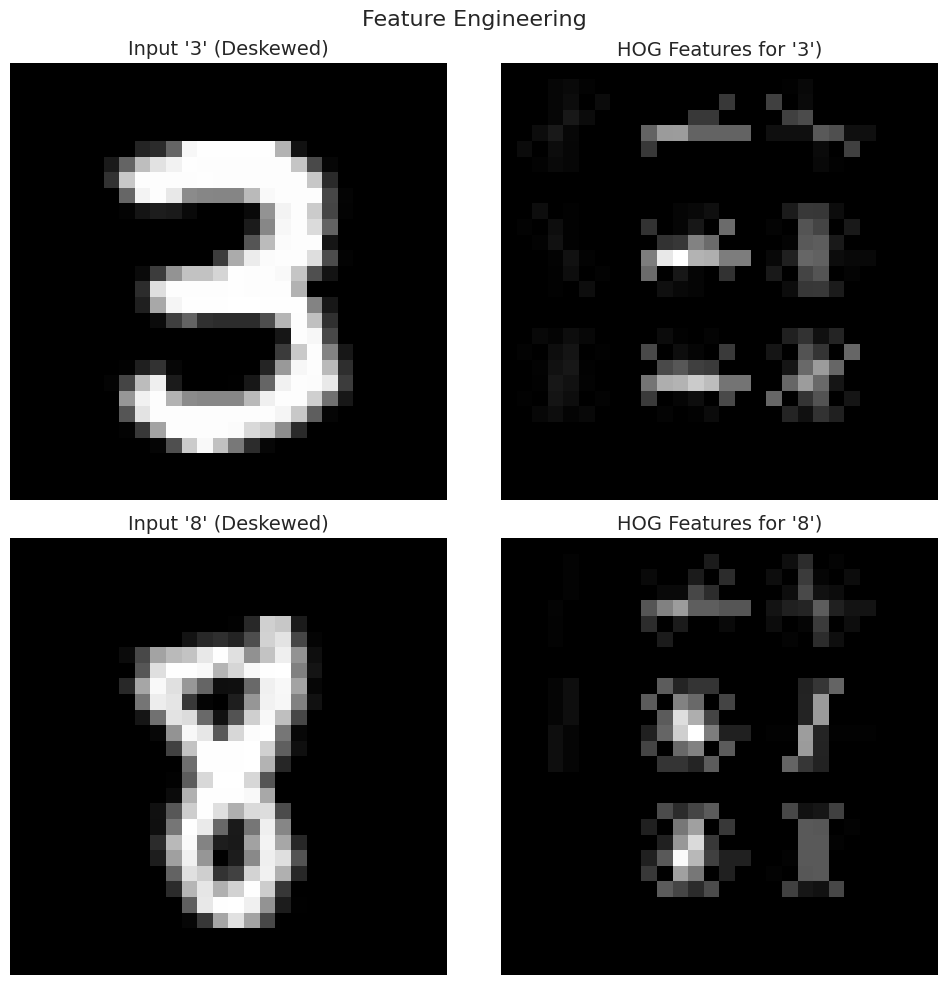

Extracting HOG features for the entire dataset:
HOG Extraction Complete in 23.99s.
New Feature Shape: (60000, 144)


In [31]:
from skimage.feature import hog
import time

hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
}

def get_hog_vis(img):
    return hog(img, **hog_params, visualize=True)

print("Visualizing HOG Features:")


idx_3 = np.where(y_train == 3)[0][0]
idx_8 = np.where(y_train == 8)[0][0]

# Get the HOG data
# Note: features_3 is the math vector (1D), vis_3 is the image (2D)
features_3, vis_3 = get_hog_vis(X_train_deskewed_img[idx_3])
features_8, vis_8 = get_hog_vis(X_train_deskewed_img[idx_8])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))


axes[0, 0].imshow(X_train_deskewed_img[idx_3], cmap='gray')
axes[0, 0].set_title("Input '3' (Deskewed)", fontsize=14)
axes[0, 0].axis('off')


axes[0, 1].imshow(vis_3, cmap='gray')
axes[0, 1].set_title("HOG Features for '3')", fontsize=14)
axes[0, 1].axis('off')

axes[1, 0].imshow(X_train_deskewed_img[idx_8], cmap='gray')
axes[1, 0].set_title("Input '8' (Deskewed)", fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(vis_8, cmap='gray')
axes[1, 1].set_title("HOG Features for '8')", fontsize=14)
axes[1, 1].axis('off')

plt.suptitle("Feature Engineering", fontsize=16)
plt.tight_layout()
plt.show()

print("Extracting HOG features for the entire dataset:")

start_hog = time.time()

X_train_hog = np.array([hog(img, **hog_params, visualize=False) for img in X_train_deskewed_img])
X_test_hog = np.array([hog(img, **hog_params, visualize=False) for img in X_test_deskewed_img])

print(f"HOG Extraction Complete in {time.time() - start_hog:.2f}s.")
print(f"New Feature Shape: {X_train_hog.shape}")